In [1]:
%reload_kedro

2023-03-28 17:40:08,395 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-03-28 17:40:09,235 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-03-28 17:40:09,378 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-03-28 17:40:09,380 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from crypto_thesis.data_domains.spine import spine_build_target_labels

### Label balancing

In [4]:
df_spine_preproc = catalog.load("spine_preprocessing")
df_spine_logret = catalog.load("spine_log_ret")
spine_params = catalog.load("params:spine_labeling")
spine_cls_bds_params = catalog.load("params:spine_class_bounds")

2023-03-28 17:40:12,771 - kedro.io.data_catalog - INFO - Loading data from `spine_preprocessing` (ParquetDataSet)...
2023-03-28 17:40:12,857 - kedro.io.data_catalog - INFO - Loading data from `spine_log_ret` (ParquetDataSet)...
2023-03-28 17:40:12,883 - kedro.io.data_catalog - INFO - Loading data from `params:spine_labeling` (MemoryDataSet)...
2023-03-28 17:40:12,888 - kedro.io.data_catalog - INFO - Loading data from `params:spine_class_bounds` (MemoryDataSet)...


In [5]:
# test a different tau value to evaluate class balancing
spine_params.update({"tau": 0.05})
spine_params

{'tau': 0.35}

In [6]:
df_spine_lbl = spine_build_target_labels(df=df_spine_preproc, 
                                         df_log_ret=df_spine_logret, 
                                         label_params=spine_params,
                                        class_bounds=spine_cls_bds_params)

2023-03-28 17:40:25,185 - crypto_thesis.data_domains.spine.build_labels - INFO - Checking for class balance


/Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis/src/crypto_thesis/data_domains/spine/build_labels.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_neg.loc[:, "label"] = "bottom"


In [7]:
df_spine_lbl.label.value_counts() / df_spine_lbl.shape[0]

bottom    0.5
top       0.5
Name: label, dtype: float64

### Volume bar time interval plots

In [8]:
df_spine = catalog.load("spine_labeled")
df_ftes = catalog.load("fte_binance").dropna()

2023-03-28 17:57:13,479 - kedro.io.data_catalog - INFO - Loading data from `spine_labeled` (ParquetDataSet)...
2023-03-28 17:57:13,776 - kedro.io.data_catalog - INFO - Loading data from `fte_binance` (ParquetDataSet)...


In [9]:
df_spine_aux = df_spine.copy()

df_spine_aux = df_spine_aux.merge(df_ftes[["open_time", "close_time"]], \
                                  on=["open_time", "close_time"] , \
                                 how="inner")

df_spine_aux.loc[:, "open_close_duration_sec"] = (df_spine_aux["close_time"] - df_spine_aux["open_time"]).dt.total_seconds()
df_spine_aux.loc[:, "close_target_duration_sec"] = (df_spine_aux["target_time"] - df_spine_aux["close_time"]).dt.total_seconds()

df_spine_aux.loc[:, "open_close_duration_min"] = df_spine_aux["open_close_duration_sec"] / 60.0
df_spine_aux.loc[:, "close_target_duration_min"] = df_spine_aux["close_target_duration_sec"] / 60.0

In [10]:
df_spine_aux.head()

,open_time,close_time,target_time,logret_cumsum,target_time_close,target_time_log_return,close_time_close,std,close_to_tgt_time_logret,label,open_close_duration_sec,close_target_duration_sec,open_close_duration_min,close_target_duration_min
0,2021-05-05 14:15:00,2021-05-06 05:00:00,2021-05-06 20:15:00,0.014985,56019.83,0.003672,56917.15,0.004204,-0.015891,bottom,53100.0,54900.0,885.0,915.0
1,2021-03-21 05:00:00,2021-03-22 06:45:00,2021-03-22 23:15:00,0.013410,54475.24,-0.003737,57678.12,0.003254,-0.057132,bottom,92700.0,59400.0,1545.0,990.0
2,2022-11-14 23:30:00,2022-11-15 04:00:00,2022-11-15 08:45:00,0.011035,16921.32,-0.000290,16832.23,0.002514,0.005279,bottom,16200.0,17100.0,270.0,285.0
3,2021-01-29 09:30:00,2021-01-29 13:00:00,2021-01-29 18:00:00,-0.005650,35289.33,-0.012724,37284.53,0.015387,-0.054998,bottom,12600.0,18000.0,210.0,300.0
4,2021-02-22 00:00:00,2021-02-22 11:45:00,2021-02-22 15:00:00,-0.051535,53377.12,-0.001904,54524.94,0.005148,-0.021276,bottom,42300.0,11700.0,705.0,195.0


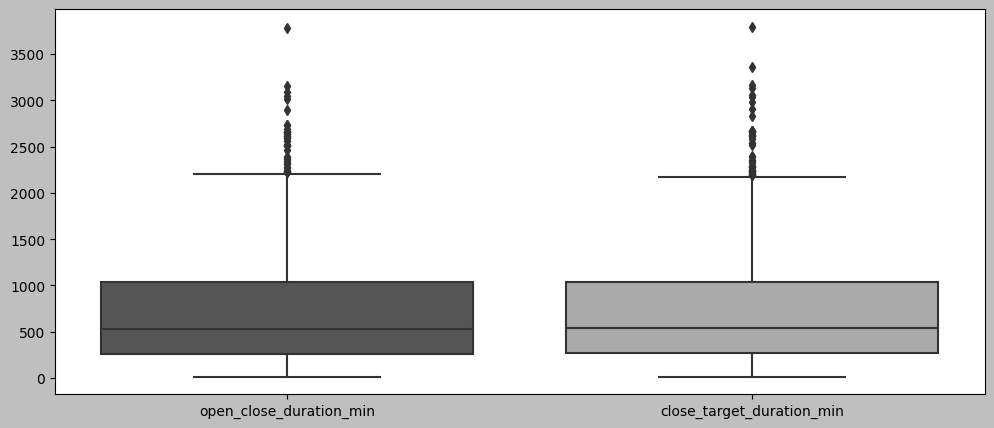

In [13]:
df_plot = df_spine_aux[["close_time", "open_close_duration_min", "close_target_duration_min"]] \
                        .set_index("close_time") \
                        .sort_index()

plt.figure(figsize=(12, 5))

# plot = sns.boxplot(data=df_plot, palette="gray")
plot = sns.boxplot(data=df_plot)

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_boxplot_time_windows.png")

In [14]:
df_plot.describe()

,open_close_duration_min,close_target_duration_min
count,1697.000000,1697.000000
mean,712.336476,727.831467
std,579.973650,583.826088
min,15.000000,15.000000
25%,255.000000,270.000000
50%,525.000000,540.000000
75%,1035.000000,1035.000000
max,3780.000000,3795.000000
